<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 1817, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 1817 (delta 81), reused 78 (delta 41), pack-reused 1686 (from 2)
Receiving objects: 100% (1817/1817), 20.81 MiB | 18.75 MiB/s, done.
Resolving deltas: 100% (1226/1226), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits, get_liver_mask
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage2
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results_stage_2

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.63% complete (down: 24276.3 kB/s up: 717.6 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.ph

## Model

In [6]:
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
model_stage_1 = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model_stage_1.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [7]:
model = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)

In [ ]:
liver_masks = get_liver_mask(config["source_folder_lits"], model_stage_1, device)

## Load data

In [ ]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2, mode="tumor", liver_masks = liver_masks)
print(len(full_train_dataset), len(val_dataset))

In [ ]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

def visualize_from_loader(image_tensor, label_tensor, liver_mask=None):
    """
    Hiển thị 3 ảnh: Volume, Liver Mask, và Liver Mask + Segmentation

    Args:
        image_tensor: Tensor, shape [1, 1, D, H, W]
        label_tensor: Tensor, shape [1, 1, D, H, W]
        liver_mask: None hoặc Tensor, shape [1, 1, D, H, W]
    Notes:
        - Chuyển đổi sang numpy
        - Hiển thị 3 ảnh: volume, liver mask, và liver mask + segmentation
    """

    # Chuyển đổi sang numpy, nén tensor về dạng [D, H, W]
    image = image_tensor.detach().cpu().numpy().squeeze()
    label = label_tensor.detach().cpu().numpy().squeeze()

    # Chọn độ sâu (ví dụ: độ sâu 40% của chiều sâu ảnh)
    depth = int(image.shape[0] * 0.4)

    # Bảng màu cho mask khối u
    cmap1 = mcolors.ListedColormap(["black", "red"])
    cmap2 = mcolors.ListedColormap(["black", "yellow"])

    # Vẽ hình
    plt.figure(figsize=(12, 6))

    # Ảnh đầu tiên: Volume (Ảnh gốc)
    plt.subplot(1, 2, 1)
    plt.title("Volume")
    plt.imshow(image[depth, :, :], cmap='gray')
    plt.axis("off")

    # Ảnh thứ ba: Liver Mask + Segmentation
    plt.subplot(1, 2, 2)
    plt.title("Liver Mask + Segmentation")
    plt.imshow(image[depth, :, :], cmap='gray')
    plt.imshow(np.max(label, 0), cmap=cmap1, alpha=0.5)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
i = 0
for train_data in train_loader:
    i+= 1
    image = train_data["image"]
    label = train_data["label"]
    liver_mask = train_data["liver_mask"]
    visualize_from_loader(image, label)
    # print(image.shape, label.shape, liver_mask.shape)
    if i== 5:
      break

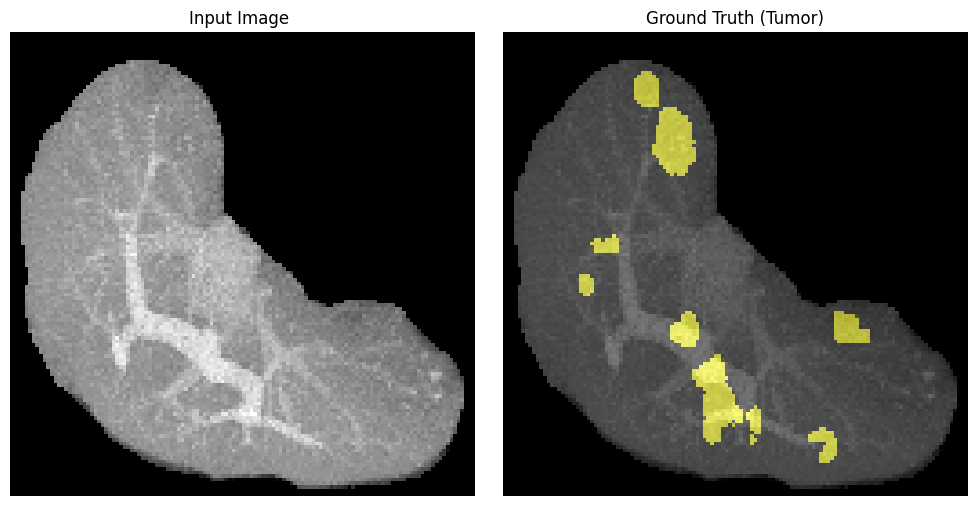

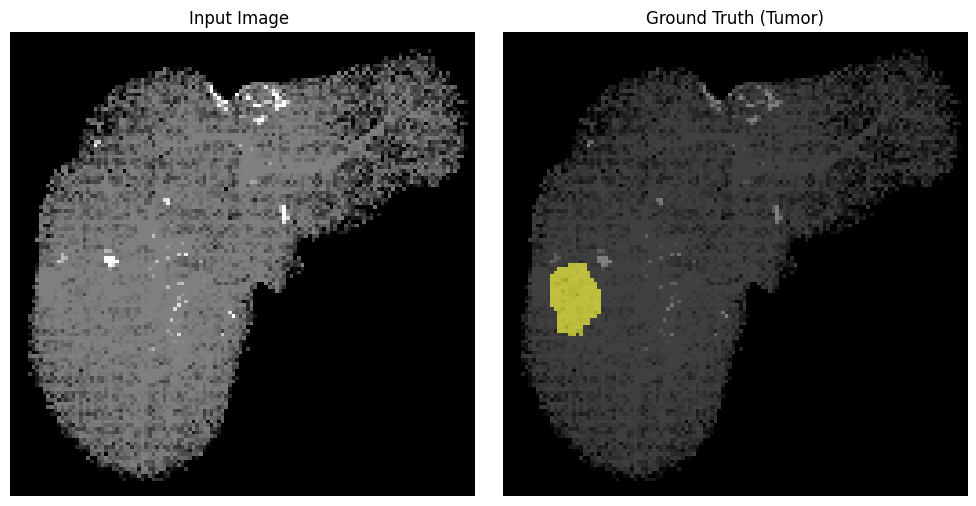

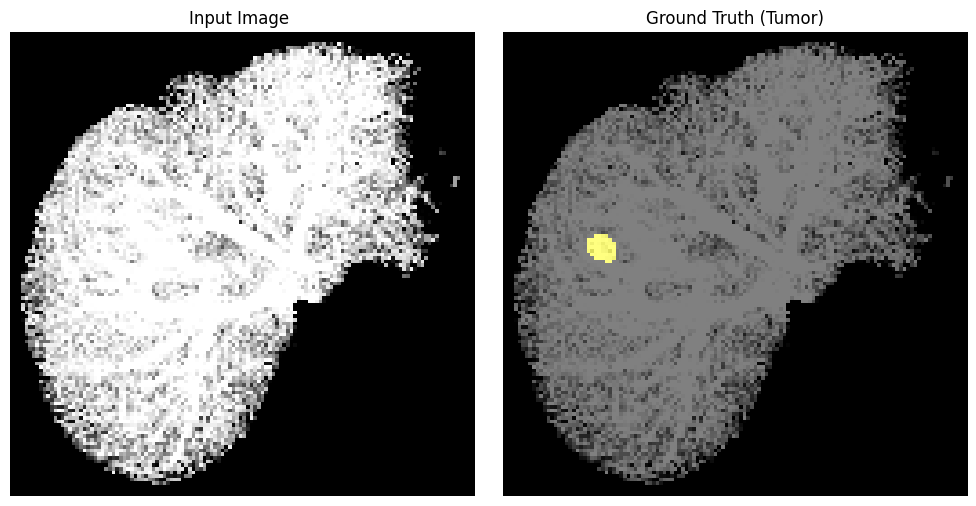

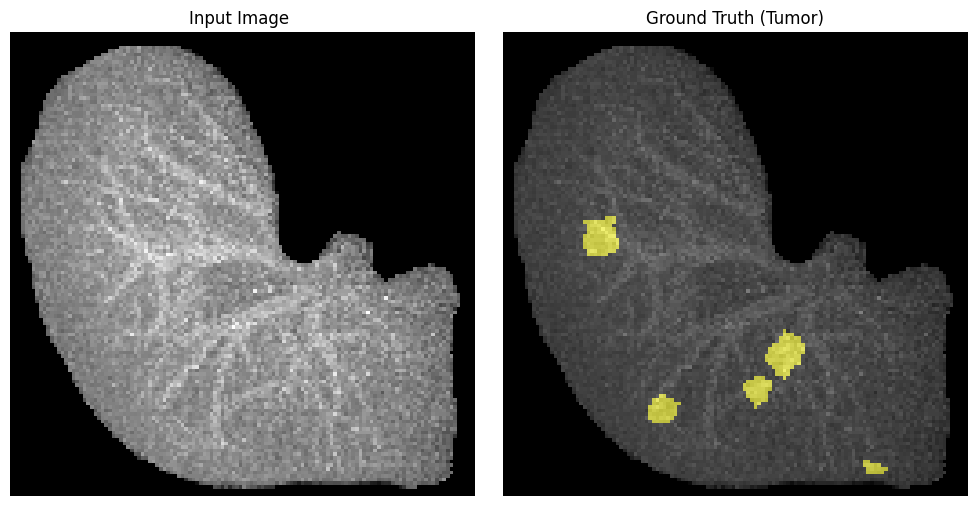

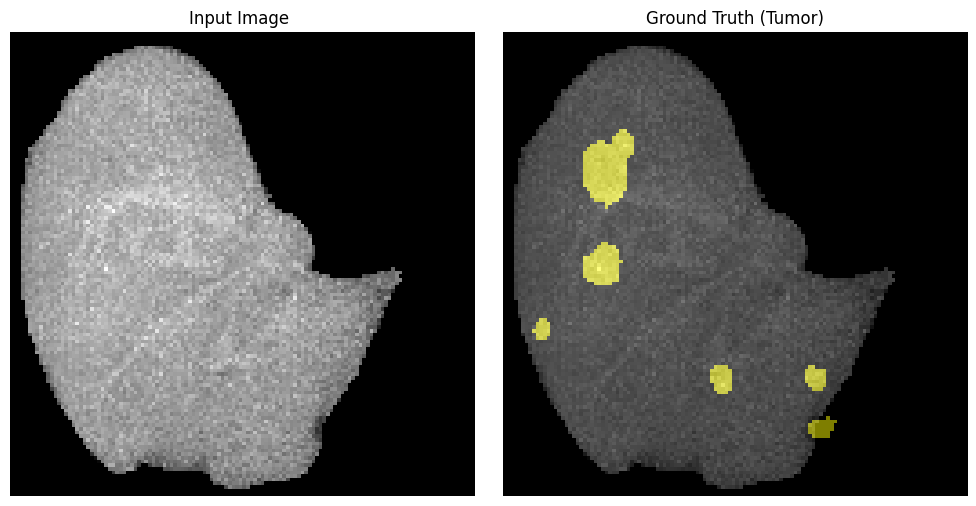

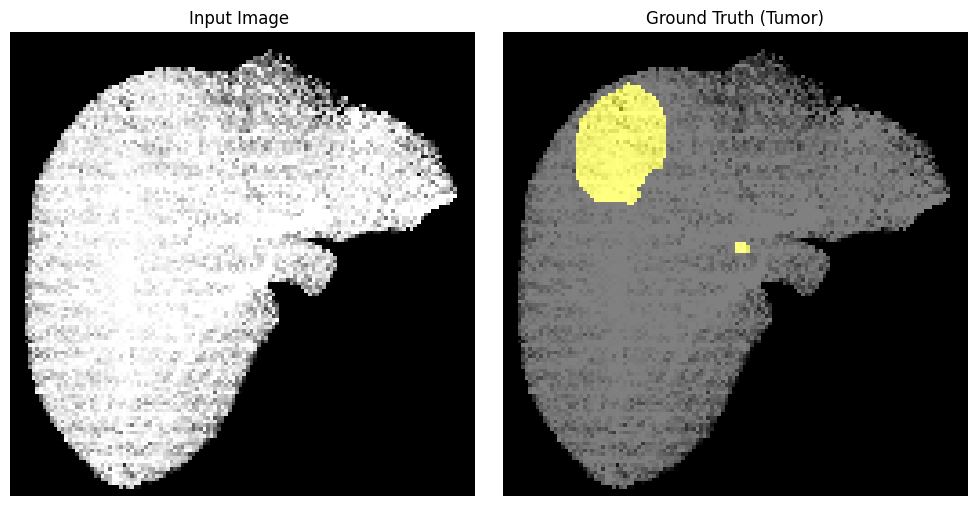

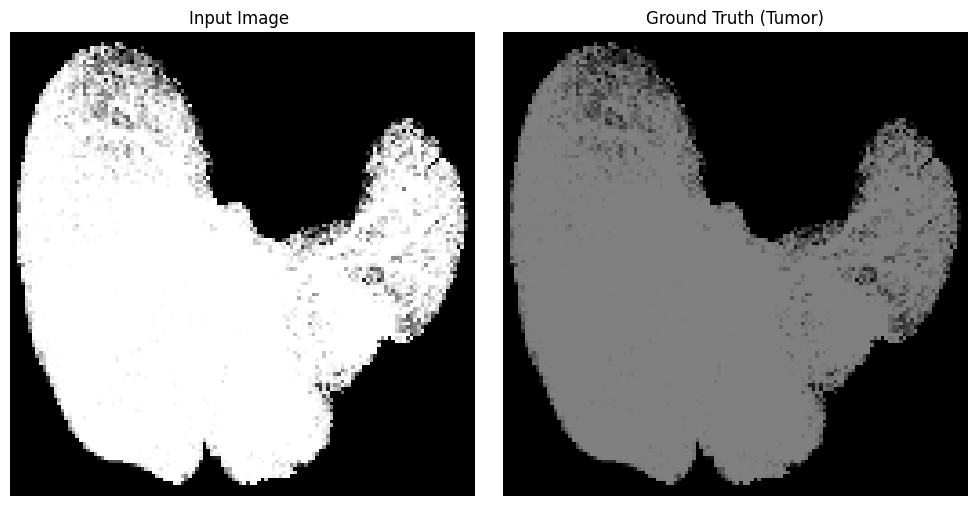

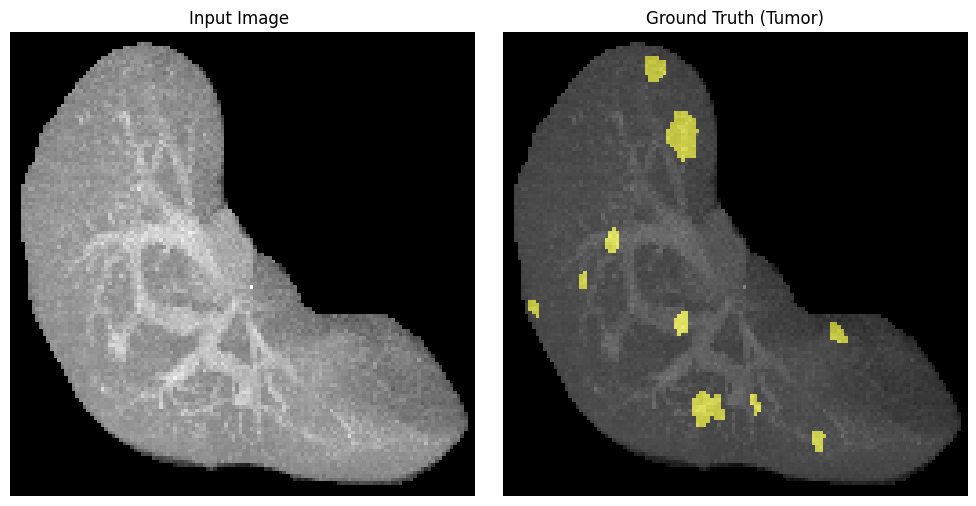

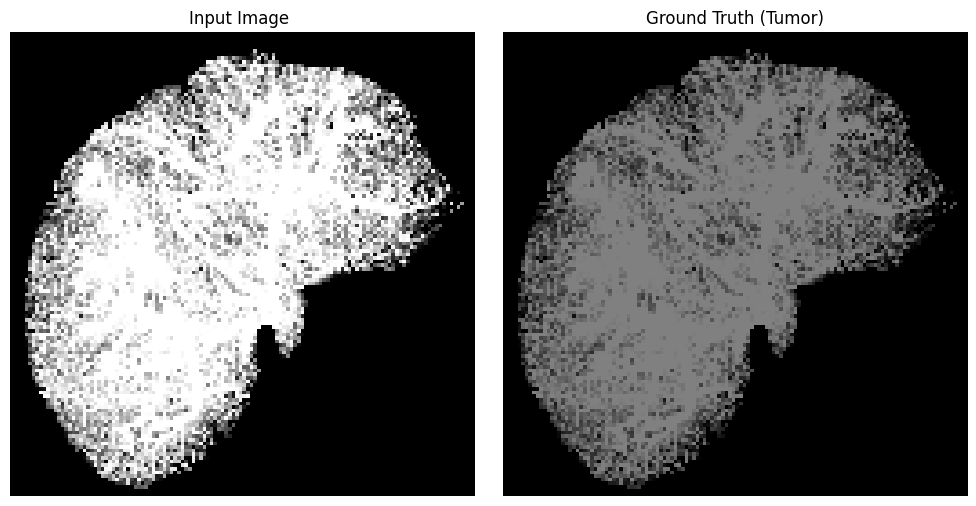

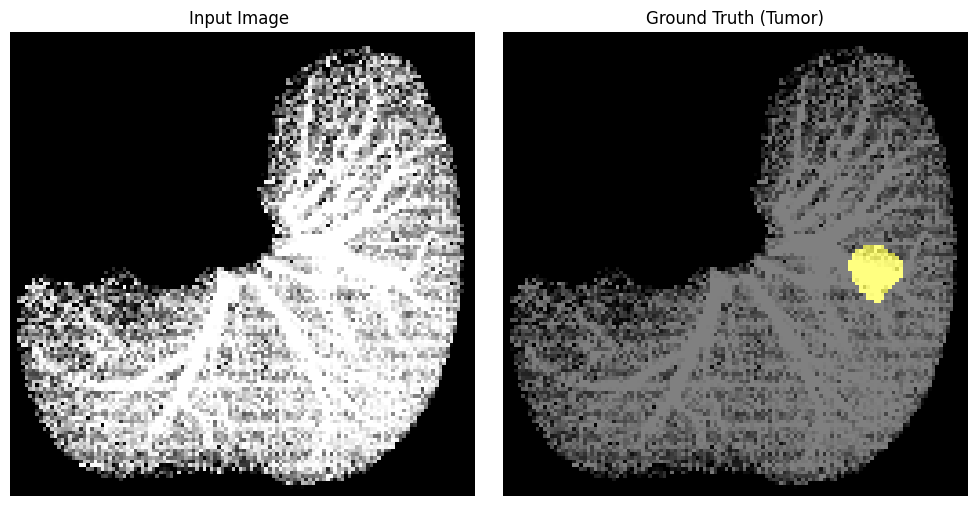

In [ ]:
i = 0
for val_data in val_loader:
    i+= 1
    image = val_data["image"]
    label = val_data["label"]
    liver_mask = val_data["liver_mask"]

    visualize_from_loader(image, label, liver_mask)
    if i == 5:
      break

## Training

In [ ]:
criterion = TverskyLossWSigmoid(use_fc=True).to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 40, T_mult = 1, eta_min = float(config["eta_min"]))

In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_tumor,
    loss_epochs,
    trains_epoch,
    ious_tumor,
    precisions_tumor,
    recalls_tumor,
    time_tmp
) = trainer_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    # max_epochs = config["max_epochs"],
    max_epochs = 20,
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=False,
    post_fix="tumor"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/20 1/105 loss: 0.7164 time 5.31s
Epoch 1/20 2/105 loss: 0.7173 time 2.59s
Epoch 1/20 3/105 loss: 0.7166 time 4.10s
Epoch 1/20 4/105 loss: 0.7009 time 0.86s
Epoch 1/20 5/105 loss: 0.7021 time 5.54s
Epoch 1/20 6/105 loss: 0.7042 time 1.22s
Epoch 1/20 7/105 loss: 0.7056 time 4.88s
Epoch 1/20 8/105 loss: 0.7036 time 11.42s
Epoch 1/20 9/105 loss: 0.7049 time 4.68s
Epoch 1/20 10/105 loss: 0.7059 time 1.17s
Epoch 1/20 11/105 loss: 0.7067 time 2.65s
Epoch 1/20 12/105 loss: 0.7067 time 0.70s
Epoch 1/20 13/105 loss: 0.7070 time 5.07s
Epoch 1/20 14/105 loss: 0.7074 time 7.01s
Epoch 1/20 15/105 loss: 0.7078 time 8.85s
Epoch 1/20 16/105 loss: 0.7081 time 0.82s
Epoch 1/20 17/105 loss: 0.7084 time 3.62s
Epoch 1/20 18/105 loss: 0.7085 time 0.67s
Epoch 1/20 19/105 loss: 0.7086 time 2.55s
Epoch 1/20 20/105 loss: 0.7067 time 2.84s
Epoch 1/20 21/105 loss: 0.7067 time 6.69s
Epoch 1/20 22/105 loss: 0.7069 time 6.53s
Epoch 1/20 23/105 loss: 0.7059 time 7.28s
Epoch 1/20 24/105 loss: 0.7061 time 0.68s


Final training epochs: 1/20 ---[loss: 0.6971] ---[time 425.15s]
INFO:kltn.utils.logger:Final training epochs: 1/20 ---[loss: 0.6971] ---[time 425.15s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/20 105/105 loss: 0.6971 time 2.47s


Val 1/20 1/26, Dice_Tumor: 0.000000, time 1.87s
INFO:kltn.utils.logger:Val 1/20 1/26, Dice_Tumor: 0.000000, time 1.87s
Val 1/20 2/26, Dice_Tumor: 0.000000, time 0.94s
INFO:kltn.utils.logger:Val 1/20 2/26, Dice_Tumor: 0.000000, time 0.94s
Val 1/20 3/26, Dice_Tumor: 0.000000, time 1.40s
INFO:kltn.utils.logger:Val 1/20 3/26, Dice_Tumor: 0.000000, time 1.40s
Val 1/20 4/26, Dice_Tumor: 0.000000, time 4.39s
INFO:kltn.utils.logger:Val 1/20 4/26, Dice_Tumor: 0.000000, time 4.39s
Val 1/20 5/26, Dice_Tumor: 0.000633, time 4.97s
INFO:kltn.utils.logger:Val 1/20 5/26, Dice_Tumor: 0.000633, time 4.97s
Val 1/20 6/26, Dice_Tumor: 0.000171, time 4.10s
INFO:kltn.utils.logger:Val 1/20 6/26, Dice_Tumor: 0.000171, time 4.10s
Val 1/20 7/26, Dice_Tumor: 0.000000, time 0.87s
INFO:kltn.utils.logger:Val 1/20 7/26, Dice_Tumor: 0.000000, time 0.87s
Val 1/20 8/26, Dice_Tumor: 0.000000, time 0.59s
INFO:kltn.utils.logger:Val 1/20 8/26, Dice_Tumor: 0.000000, time 0.59s
Val 1/20 9/26, Dice_Tumor: 0.000000, time 5.96s


New best (0.000000 --> 0.000144). At epoch 1
Epoch 2/20 1/105 loss: 0.7059 time 1.31s
Epoch 2/20 2/105 loss: 0.7048 time 4.58s
Epoch 2/20 3/105 loss: 0.7054 time 4.45s
Epoch 2/20 4/105 loss: 0.6943 time 6.04s
Epoch 2/20 5/105 loss: 0.6968 time 3.40s
Epoch 2/20 6/105 loss: 0.6926 time 5.37s
Epoch 2/20 7/105 loss: 0.6928 time 3.79s
Epoch 2/20 8/105 loss: 0.6929 time 3.30s
Epoch 2/20 9/105 loss: 0.6941 time 1.66s
Epoch 2/20 10/105 loss: 0.6953 time 0.83s
Epoch 2/20 11/105 loss: 0.6941 time 1.26s
Epoch 2/20 12/105 loss: 0.6951 time 4.88s
Epoch 2/20 13/105 loss: 0.6960 time 1.12s
Epoch 2/20 14/105 loss: 0.6964 time 3.07s
Epoch 2/20 15/105 loss: 0.6933 time 12.02s
Epoch 2/20 16/105 loss: 0.6941 time 0.97s
Epoch 2/20 17/105 loss: 0.6943 time 5.72s
Epoch 2/20 18/105 loss: 0.6949 time 4.18s
Epoch 2/20 19/105 loss: 0.6954 time 6.40s
Epoch 2/20 20/105 loss: 0.6959 time 4.67s
Epoch 2/20 21/105 loss: 0.6964 time 5.43s
Epoch 2/20 22/105 loss: 0.6920 time 7.17s
Epoch 2/20 23/105 loss: 0.6926 time 4.9

Final training epochs: 2/20 ---[loss: 0.6897] ---[time 419.94s]
INFO:kltn.utils.logger:Final training epochs: 2/20 ---[loss: 0.6897] ---[time 419.94s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/20 105/105 loss: 0.6897 time 11.17s


Val 2/20 1/26, Dice_Tumor: 0.000000, time 1.17s
INFO:kltn.utils.logger:Val 2/20 1/26, Dice_Tumor: 0.000000, time 1.17s
Val 2/20 2/26, Dice_Tumor: 0.000000, time 1.21s
INFO:kltn.utils.logger:Val 2/20 2/26, Dice_Tumor: 0.000000, time 1.21s
Val 2/20 3/26, Dice_Tumor: 0.000000, time 1.11s
INFO:kltn.utils.logger:Val 2/20 3/26, Dice_Tumor: 0.000000, time 1.11s
Val 2/20 4/26, Dice_Tumor: 0.000000, time 3.31s
INFO:kltn.utils.logger:Val 2/20 4/26, Dice_Tumor: 0.000000, time 3.31s
Val 2/20 5/26, Dice_Tumor: 0.000000, time 5.04s
INFO:kltn.utils.logger:Val 2/20 5/26, Dice_Tumor: 0.000000, time 5.04s
Val 2/20 6/26, Dice_Tumor: 0.000000, time 4.16s
INFO:kltn.utils.logger:Val 2/20 6/26, Dice_Tumor: 0.000000, time 4.16s
Val 2/20 7/26, Dice_Tumor: 0.000000, time 0.88s
INFO:kltn.utils.logger:Val 2/20 7/26, Dice_Tumor: 0.000000, time 0.88s
Val 2/20 8/26, Dice_Tumor: 0.000000, time 0.57s
INFO:kltn.utils.logger:Val 2/20 8/26, Dice_Tumor: 0.000000, time 0.57s
Val 2/20 9/26, Dice_Tumor: 0.000000, time 5.82s


Epoch 3/20 1/105 loss: 0.7043 time 5.59s
Epoch 3/20 2/105 loss: 0.7044 time 5.03s
Epoch 3/20 3/105 loss: 0.7047 time 3.07s
Epoch 3/20 4/105 loss: 0.7022 time 5.56s
Epoch 3/20 5/105 loss: 0.7019 time 4.94s
Epoch 3/20 6/105 loss: 0.7024 time 7.49s
Epoch 3/20 7/105 loss: 0.7028 time 7.22s
Epoch 3/20 8/105 loss: 0.7013 time 2.83s
Epoch 3/20 9/105 loss: 0.7000 time 1.48s
Epoch 3/20 10/105 loss: 0.6940 time 6.56s
Epoch 3/20 11/105 loss: 0.6948 time 1.26s
Epoch 3/20 12/105 loss: 0.6935 time 0.94s
Epoch 3/20 13/105 loss: 0.6940 time 4.68s
Epoch 3/20 14/105 loss: 0.6939 time 9.98s
Epoch 3/20 15/105 loss: 0.6946 time 4.02s
Epoch 3/20 16/105 loss: 0.6945 time 2.64s
Epoch 3/20 17/105 loss: 0.6918 time 7.44s
Epoch 3/20 18/105 loss: 0.6893 time 1.18s
Epoch 3/20 19/105 loss: 0.6901 time 2.67s
Epoch 3/20 20/105 loss: 0.6908 time 5.78s
Epoch 3/20 21/105 loss: 0.6914 time 0.97s
Epoch 3/20 22/105 loss: 0.6920 time 2.29s
Epoch 3/20 23/105 loss: 0.6903 time 1.51s
Epoch 3/20 24/105 loss: 0.6870 time 1.03s
E

Final training epochs: 3/20 ---[loss: 0.6850] ---[time 427.54s]
INFO:kltn.utils.logger:Final training epochs: 3/20 ---[loss: 0.6850] ---[time 427.54s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/20 105/105 loss: 0.6850 time 6.06s


Val 3/20 1/26, Dice_Tumor: 0.000870, time 1.04s
INFO:kltn.utils.logger:Val 3/20 1/26, Dice_Tumor: 0.000870, time 1.04s
Val 3/20 2/26, Dice_Tumor: 0.000000, time 1.65s
INFO:kltn.utils.logger:Val 3/20 2/26, Dice_Tumor: 0.000000, time 1.65s
Val 3/20 3/26, Dice_Tumor: 0.000000, time 1.50s
INFO:kltn.utils.logger:Val 3/20 3/26, Dice_Tumor: 0.000000, time 1.50s
Val 3/20 4/26, Dice_Tumor: 0.000000, time 4.20s
INFO:kltn.utils.logger:Val 3/20 4/26, Dice_Tumor: 0.000000, time 4.20s
Val 3/20 5/26, Dice_Tumor: 0.000633, time 4.31s
INFO:kltn.utils.logger:Val 3/20 5/26, Dice_Tumor: 0.000633, time 4.31s
Val 3/20 6/26, Dice_Tumor: 0.000000, time 4.99s
INFO:kltn.utils.logger:Val 3/20 6/26, Dice_Tumor: 0.000000, time 4.99s
Val 3/20 7/26, Dice_Tumor: 0.000000, time 0.89s
INFO:kltn.utils.logger:Val 3/20 7/26, Dice_Tumor: 0.000000, time 0.89s
Val 3/20 8/26, Dice_Tumor: 0.001977, time 0.61s
INFO:kltn.utils.logger:Val 3/20 8/26, Dice_Tumor: 0.001977, time 0.61s
Val 3/20 9/26, Dice_Tumor: 0.000000, time 5.74s


New best (0.000144 --> 0.000358). At epoch 3
Epoch 4/20 1/105 loss: 0.7041 time 1.48s
Epoch 4/20 2/105 loss: 0.7009 time 3.73s
Epoch 4/20 3/105 loss: 0.7022 time 5.02s
Epoch 4/20 4/105 loss: 0.7029 time 1.23s
Epoch 4/20 5/105 loss: 0.6861 time 2.62s
Epoch 4/20 6/105 loss: 0.6891 time 4.90s
Epoch 4/20 7/105 loss: 0.6909 time 0.97s
Epoch 4/20 8/105 loss: 0.6926 time 2.65s
Epoch 4/20 9/105 loss: 0.6939 time 5.70s
Epoch 4/20 10/105 loss: 0.6926 time 3.94s
Epoch 4/20 11/105 loss: 0.6906 time 1.74s
Epoch 4/20 12/105 loss: 0.6916 time 6.14s
Epoch 4/20 13/105 loss: 0.6906 time 4.80s
Epoch 4/20 14/105 loss: 0.6916 time 15.12s
Epoch 4/20 15/105 loss: 0.6923 time 6.08s
Epoch 4/20 16/105 loss: 0.6908 time 4.24s
Epoch 4/20 17/105 loss: 0.6913 time 4.76s
Epoch 4/20 18/105 loss: 0.6874 time 1.36s
Epoch 4/20 19/105 loss: 0.6870 time 5.16s
Epoch 4/20 20/105 loss: 0.6879 time 1.10s
Epoch 4/20 21/105 loss: 0.6865 time 6.86s
Epoch 4/20 22/105 loss: 0.6873 time 8.43s
Epoch 4/20 23/105 loss: 0.6880 time 1.5

Final training epochs: 4/20 ---[loss: 0.6819] ---[time 452.88s]
INFO:kltn.utils.logger:Final training epochs: 4/20 ---[loss: 0.6819] ---[time 452.88s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/20 105/105 loss: 0.6819 time 3.27s


Val 4/20 1/26, Dice_Tumor: 0.000435, time 1.22s
INFO:kltn.utils.logger:Val 4/20 1/26, Dice_Tumor: 0.000435, time 1.22s
Val 4/20 2/26, Dice_Tumor: 0.000736, time 1.60s
INFO:kltn.utils.logger:Val 4/20 2/26, Dice_Tumor: 0.000736, time 1.60s
Val 4/20 3/26, Dice_Tumor: 0.000000, time 1.92s
INFO:kltn.utils.logger:Val 4/20 3/26, Dice_Tumor: 0.000000, time 1.92s
Val 4/20 4/26, Dice_Tumor: 0.000000, time 4.54s
INFO:kltn.utils.logger:Val 4/20 4/26, Dice_Tumor: 0.000000, time 4.54s
Val 4/20 5/26, Dice_Tumor: 0.000000, time 4.78s
INFO:kltn.utils.logger:Val 4/20 5/26, Dice_Tumor: 0.000000, time 4.78s
Val 4/20 6/26, Dice_Tumor: 0.000170, time 5.49s
INFO:kltn.utils.logger:Val 4/20 6/26, Dice_Tumor: 0.000170, time 5.49s
Val 4/20 7/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 4/20 7/26, Dice_Tumor: 0.000000, time 1.02s
Val 4/20 8/26, Dice_Tumor: 0.000000, time 0.65s
INFO:kltn.utils.logger:Val 4/20 8/26, Dice_Tumor: 0.000000, time 0.65s
Val 4/20 9/26, Dice_Tumor: 0.000000, time 6.36s


Epoch 5/20 1/105 loss: 0.7022 time 1.37s
Epoch 5/20 2/105 loss: 0.6876 time 2.31s
Epoch 5/20 3/105 loss: 0.6934 time 16.40s
Epoch 5/20 4/105 loss: 0.6844 time 1.77s
Epoch 5/20 5/105 loss: 0.6878 time 5.80s
Epoch 5/20 6/105 loss: 0.6886 time 6.35s
Epoch 5/20 7/105 loss: 0.6908 time 4.72s
Epoch 5/20 8/105 loss: 0.6925 time 4.94s
Epoch 5/20 9/105 loss: 0.6939 time 1.11s
Epoch 5/20 10/105 loss: 0.6947 time 4.40s
Epoch 5/20 11/105 loss: 0.6809 time 5.28s
Epoch 5/20 12/105 loss: 0.6749 time 2.50s
Epoch 5/20 13/105 loss: 0.6671 time 4.30s
Epoch 5/20 14/105 loss: 0.6629 time 1.83s
Epoch 5/20 15/105 loss: 0.6650 time 5.28s
Epoch 5/20 16/105 loss: 0.6674 time 5.87s
Epoch 5/20 17/105 loss: 0.6645 time 7.77s
Epoch 5/20 18/105 loss: 0.6662 time 4.52s
Epoch 5/20 19/105 loss: 0.6655 time 1.01s
Epoch 5/20 20/105 loss: 0.6672 time 4.13s
Epoch 5/20 21/105 loss: 0.6690 time 3.13s
Epoch 5/20 22/105 loss: 0.6706 time 4.62s
Epoch 5/20 23/105 loss: 0.6714 time 3.80s
Epoch 5/20 24/105 loss: 0.6728 time 2.81s


Final training epochs: 5/20 ---[loss: 0.6772] ---[time 469.10s]
INFO:kltn.utils.logger:Final training epochs: 5/20 ---[loss: 0.6772] ---[time 469.10s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/20 105/105 loss: 0.6772 time 6.09s


Val 5/20 1/26, Dice_Tumor: 0.000000, time 1.24s
INFO:kltn.utils.logger:Val 5/20 1/26, Dice_Tumor: 0.000000, time 1.24s
Val 5/20 2/26, Dice_Tumor: 0.000000, time 1.39s
INFO:kltn.utils.logger:Val 5/20 2/26, Dice_Tumor: 0.000000, time 1.39s
Val 5/20 3/26, Dice_Tumor: 0.000000, time 1.34s
INFO:kltn.utils.logger:Val 5/20 3/26, Dice_Tumor: 0.000000, time 1.34s
Val 5/20 4/26, Dice_Tumor: 0.000000, time 4.77s
INFO:kltn.utils.logger:Val 5/20 4/26, Dice_Tumor: 0.000000, time 4.77s
Val 5/20 5/26, Dice_Tumor: 0.000000, time 4.84s
INFO:kltn.utils.logger:Val 5/20 5/26, Dice_Tumor: 0.000000, time 4.84s
Val 5/20 6/26, Dice_Tumor: 0.000000, time 4.86s
INFO:kltn.utils.logger:Val 5/20 6/26, Dice_Tumor: 0.000000, time 4.86s
Val 5/20 7/26, Dice_Tumor: 0.000000, time 0.97s
INFO:kltn.utils.logger:Val 5/20 7/26, Dice_Tumor: 0.000000, time 0.97s
Val 5/20 8/26, Dice_Tumor: 0.000000, time 0.65s
INFO:kltn.utils.logger:Val 5/20 8/26, Dice_Tumor: 0.000000, time 0.65s
Val 5/20 9/26, Dice_Tumor: 0.000000, time 6.39s


Epoch 6/20 1/105 loss: 0.6812 time 1.48s
Epoch 6/20 2/105 loss: 0.6900 time 1.21s
Epoch 6/20 3/105 loss: 0.6752 time 5.93s
Epoch 6/20 4/105 loss: 0.6499 time 10.11s
Epoch 6/20 5/105 loss: 0.6600 time 1.29s
Epoch 6/20 6/105 loss: 0.6657 time 8.23s
Epoch 6/20 7/105 loss: 0.6709 time 1.11s
Epoch 6/20 8/105 loss: 0.6751 time 8.11s
Epoch 6/20 9/105 loss: 0.6780 time 4.35s
Epoch 6/20 10/105 loss: 0.6805 time 1.15s
Epoch 6/20 11/105 loss: 0.6820 time 4.94s
Epoch 6/20 12/105 loss: 0.6798 time 5.42s
Epoch 6/20 13/105 loss: 0.6817 time 2.63s
Epoch 6/20 14/105 loss: 0.6833 time 0.87s
Epoch 6/20 15/105 loss: 0.6833 time 3.40s
Epoch 6/20 16/105 loss: 0.6813 time 5.55s
Epoch 6/20 17/105 loss: 0.6826 time 15.37s
Epoch 6/20 18/105 loss: 0.6837 time 0.71s
Epoch 6/20 19/105 loss: 0.6815 time 1.05s
Epoch 6/20 20/105 loss: 0.6736 time 13.09s
Epoch 6/20 21/105 loss: 0.6733 time 2.05s
Epoch 6/20 22/105 loss: 0.6703 time 7.77s
Epoch 6/20 23/105 loss: 0.6718 time 4.54s
Epoch 6/20 24/105 loss: 0.6691 time 1.28

Final training epochs: 6/20 ---[loss: 0.6720] ---[time 473.87s]
INFO:kltn.utils.logger:Final training epochs: 6/20 ---[loss: 0.6720] ---[time 473.87s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/20 105/105 loss: 0.6720 time 9.91s


Val 6/20 1/26, Dice_Tumor: 0.000871, time 1.16s
INFO:kltn.utils.logger:Val 6/20 1/26, Dice_Tumor: 0.000871, time 1.16s
Val 6/20 2/26, Dice_Tumor: 0.000743, time 1.42s
INFO:kltn.utils.logger:Val 6/20 2/26, Dice_Tumor: 0.000743, time 1.42s
Val 6/20 3/26, Dice_Tumor: 0.000000, time 1.33s
INFO:kltn.utils.logger:Val 6/20 3/26, Dice_Tumor: 0.000000, time 1.33s
Val 6/20 4/26, Dice_Tumor: 0.001347, time 4.97s
INFO:kltn.utils.logger:Val 6/20 4/26, Dice_Tumor: 0.001347, time 4.97s
Val 6/20 5/26, Dice_Tumor: 0.000000, time 4.38s
INFO:kltn.utils.logger:Val 6/20 5/26, Dice_Tumor: 0.000000, time 4.38s
Val 6/20 6/26, Dice_Tumor: 0.000171, time 5.01s
INFO:kltn.utils.logger:Val 6/20 6/26, Dice_Tumor: 0.000171, time 5.01s
Val 6/20 7/26, Dice_Tumor: 0.000000, time 1.19s
INFO:kltn.utils.logger:Val 6/20 7/26, Dice_Tumor: 0.000000, time 1.19s
Val 6/20 8/26, Dice_Tumor: 0.000000, time 0.80s
INFO:kltn.utils.logger:Val 6/20 8/26, Dice_Tumor: 0.000000, time 0.80s
Val 6/20 9/26, Dice_Tumor: 0.000000, time 6.03s


New best (0.000358 --> 0.000385). At epoch 6
Epoch 7/20 1/105 loss: 0.7018 time 1.94s
Epoch 7/20 2/105 loss: 0.6874 time 1.08s
Epoch 7/20 3/105 loss: 0.6916 time 1.16s
Epoch 7/20 4/105 loss: 0.6853 time 6.35s
Epoch 7/20 5/105 loss: 0.6882 time 1.52s
Epoch 7/20 6/105 loss: 0.6907 time 0.79s
Epoch 7/20 7/105 loss: 0.6927 time 7.41s
Epoch 7/20 8/105 loss: 0.6886 time 5.70s
Epoch 7/20 9/105 loss: 0.6685 time 5.59s
Epoch 7/20 10/105 loss: 0.6720 time 6.60s
Epoch 7/20 11/105 loss: 0.6748 time 1.08s
Epoch 7/20 12/105 loss: 0.6590 time 11.67s
Epoch 7/20 13/105 loss: 0.6624 time 2.31s
Epoch 7/20 14/105 loss: 0.6653 time 5.24s
Epoch 7/20 15/105 loss: 0.6679 time 3.37s
Epoch 7/20 16/105 loss: 0.6699 time 4.67s
Epoch 7/20 17/105 loss: 0.6718 time 5.67s
Epoch 7/20 18/105 loss: 0.6721 time 2.02s
Epoch 7/20 19/105 loss: 0.6649 time 1.18s
Epoch 7/20 20/105 loss: 0.6665 time 5.24s
Epoch 7/20 21/105 loss: 0.6680 time 6.71s
Epoch 7/20 22/105 loss: 0.6696 time 2.63s
Epoch 7/20 23/105 loss: 0.6709 time 4.4

Final training epochs: 7/20 ---[loss: 0.6685] ---[time 490.61s]
INFO:kltn.utils.logger:Final training epochs: 7/20 ---[loss: 0.6685] ---[time 490.61s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/20 105/105 loss: 0.6685 time 5.46s


Val 7/20 1/26, Dice_Tumor: 0.000000, time 1.16s
INFO:kltn.utils.logger:Val 7/20 1/26, Dice_Tumor: 0.000000, time 1.16s
Val 7/20 2/26, Dice_Tumor: 0.000744, time 1.45s
INFO:kltn.utils.logger:Val 7/20 2/26, Dice_Tumor: 0.000744, time 1.45s
Val 7/20 3/26, Dice_Tumor: 0.000000, time 1.44s
INFO:kltn.utils.logger:Val 7/20 3/26, Dice_Tumor: 0.000000, time 1.44s
Val 7/20 4/26, Dice_Tumor: 0.000000, time 4.83s
INFO:kltn.utils.logger:Val 7/20 4/26, Dice_Tumor: 0.000000, time 4.83s
Val 7/20 5/26, Dice_Tumor: 0.000000, time 4.60s
INFO:kltn.utils.logger:Val 7/20 5/26, Dice_Tumor: 0.000000, time 4.60s
Val 7/20 6/26, Dice_Tumor: 0.000342, time 5.46s
INFO:kltn.utils.logger:Val 7/20 6/26, Dice_Tumor: 0.000342, time 5.46s
Val 7/20 7/26, Dice_Tumor: 0.000000, time 1.17s
INFO:kltn.utils.logger:Val 7/20 7/26, Dice_Tumor: 0.000000, time 1.17s
Val 7/20 8/26, Dice_Tumor: 0.000000, time 0.66s
INFO:kltn.utils.logger:Val 7/20 8/26, Dice_Tumor: 0.000000, time 0.66s
Val 7/20 9/26, Dice_Tumor: 0.000000, time 6.34s


Epoch 8/20 1/105 loss: 0.6965 time 1.86s
Epoch 8/20 2/105 loss: 0.6890 time 1.42s
Epoch 8/20 3/105 loss: 0.6935 time 6.62s
Epoch 8/20 4/105 loss: 0.6847 time 1.45s
Epoch 8/20 5/105 loss: 0.6879 time 4.38s
Epoch 8/20 6/105 loss: 0.6607 time 0.95s
Epoch 8/20 7/105 loss: 0.6668 time 6.36s
Epoch 8/20 8/105 loss: 0.6613 time 13.47s
Epoch 8/20 9/105 loss: 0.6512 time 8.14s
Epoch 8/20 10/105 loss: 0.6437 time 2.80s
Epoch 8/20 11/105 loss: 0.6461 time 5.76s
Epoch 8/20 12/105 loss: 0.6508 time 1.37s
Epoch 8/20 13/105 loss: 0.6467 time 8.12s
Epoch 8/20 14/105 loss: 0.6508 time 3.90s
Epoch 8/20 15/105 loss: 0.6531 time 0.79s
Epoch 8/20 16/105 loss: 0.6556 time 5.28s
Epoch 8/20 17/105 loss: 0.6497 time 8.20s
Epoch 8/20 18/105 loss: 0.6526 time 1.05s
Epoch 8/20 19/105 loss: 0.6526 time 5.04s
Epoch 8/20 20/105 loss: 0.6548 time 4.07s
Epoch 8/20 21/105 loss: 0.6570 time 1.18s
Epoch 8/20 22/105 loss: 0.6592 time 4.83s
Epoch 8/20 23/105 loss: 0.6581 time 7.53s
Epoch 8/20 24/105 loss: 0.6572 time 1.82s


Final training epochs: 8/20 ---[loss: 0.6620] ---[time 490.16s]
INFO:kltn.utils.logger:Final training epochs: 8/20 ---[loss: 0.6620] ---[time 490.16s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/20 105/105 loss: 0.6620 time 1.29s


Val 8/20 1/26, Dice_Tumor: 0.000000, time 1.40s
INFO:kltn.utils.logger:Val 8/20 1/26, Dice_Tumor: 0.000000, time 1.40s
Val 8/20 2/26, Dice_Tumor: 0.000000, time 1.93s
INFO:kltn.utils.logger:Val 8/20 2/26, Dice_Tumor: 0.000000, time 1.93s
Val 8/20 3/26, Dice_Tumor: 0.000000, time 1.54s
INFO:kltn.utils.logger:Val 8/20 3/26, Dice_Tumor: 0.000000, time 1.54s
Val 8/20 4/26, Dice_Tumor: 0.000000, time 4.51s
INFO:kltn.utils.logger:Val 8/20 4/26, Dice_Tumor: 0.000000, time 4.51s
Val 8/20 5/26, Dice_Tumor: 0.000000, time 4.95s
INFO:kltn.utils.logger:Val 8/20 5/26, Dice_Tumor: 0.000000, time 4.95s
Val 8/20 6/26, Dice_Tumor: 0.001024, time 4.81s
INFO:kltn.utils.logger:Val 8/20 6/26, Dice_Tumor: 0.001024, time 4.81s
Val 8/20 7/26, Dice_Tumor: 0.000000, time 0.95s
INFO:kltn.utils.logger:Val 8/20 7/26, Dice_Tumor: 0.000000, time 0.95s
Val 8/20 8/26, Dice_Tumor: 0.000000, time 0.68s
INFO:kltn.utils.logger:Val 8/20 8/26, Dice_Tumor: 0.000000, time 0.68s
Val 8/20 9/26, Dice_Tumor: 0.000000, time 6.83s


Epoch 9/20 1/105 loss: 0.4959 time 4.47s
Epoch 9/20 2/105 loss: 0.5783 time 11.52s
Epoch 9/20 3/105 loss: 0.6203 time 4.06s
Epoch 9/20 4/105 loss: 0.6390 time 3.85s
Epoch 9/20 5/105 loss: 0.5984 time 11.29s
Epoch 9/20 6/105 loss: 0.6159 time 5.71s
Epoch 9/20 7/105 loss: 0.6274 time 5.63s
Epoch 9/20 8/105 loss: 0.6321 time 2.80s
Epoch 9/20 9/105 loss: 0.6346 time 6.33s
Epoch 9/20 10/105 loss: 0.6415 time 4.82s
Epoch 9/20 11/105 loss: 0.6454 time 5.90s
Epoch 9/20 12/105 loss: 0.6503 time 6.22s
Epoch 9/20 13/105 loss: 0.6545 time 4.66s
Epoch 9/20 14/105 loss: 0.6580 time 0.73s
Epoch 9/20 15/105 loss: 0.6609 time 6.02s
Epoch 9/20 16/105 loss: 0.6570 time 1.07s
Epoch 9/20 17/105 loss: 0.6597 time 4.35s
Epoch 9/20 18/105 loss: 0.6603 time 1.62s
Epoch 9/20 19/105 loss: 0.6624 time 5.24s
Epoch 9/20 20/105 loss: 0.6644 time 2.37s
Epoch 9/20 21/105 loss: 0.6642 time 5.47s
Epoch 9/20 22/105 loss: 0.6595 time 1.98s
Epoch 9/20 23/105 loss: 0.6613 time 1.58s
Epoch 9/20 24/105 loss: 0.6618 time 2.79s

Final training epochs: 9/20 ---[loss: 0.6574] ---[time 478.59s]
INFO:kltn.utils.logger:Final training epochs: 9/20 ---[loss: 0.6574] ---[time 478.59s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/20 105/105 loss: 0.6574 time 7.96s


Val 9/20 1/26, Dice_Tumor: 0.000437, time 1.24s
INFO:kltn.utils.logger:Val 9/20 1/26, Dice_Tumor: 0.000437, time 1.24s
Val 9/20 2/26, Dice_Tumor: 0.000000, time 1.40s
INFO:kltn.utils.logger:Val 9/20 2/26, Dice_Tumor: 0.000000, time 1.40s
Val 9/20 3/26, Dice_Tumor: 0.000000, time 1.28s
INFO:kltn.utils.logger:Val 9/20 3/26, Dice_Tumor: 0.000000, time 1.28s
Val 9/20 4/26, Dice_Tumor: 0.000000, time 5.40s
INFO:kltn.utils.logger:Val 9/20 4/26, Dice_Tumor: 0.000000, time 5.40s
Val 9/20 5/26, Dice_Tumor: 0.000000, time 4.58s
INFO:kltn.utils.logger:Val 9/20 5/26, Dice_Tumor: 0.000000, time 4.58s
Val 9/20 6/26, Dice_Tumor: 0.000171, time 4.72s
INFO:kltn.utils.logger:Val 9/20 6/26, Dice_Tumor: 0.000171, time 4.72s
Val 9/20 7/26, Dice_Tumor: 0.000000, time 1.19s
INFO:kltn.utils.logger:Val 9/20 7/26, Dice_Tumor: 0.000000, time 1.19s
Val 9/20 8/26, Dice_Tumor: 0.000993, time 0.81s
INFO:kltn.utils.logger:Val 9/20 8/26, Dice_Tumor: 0.000993, time 0.81s
Val 9/20 9/26, Dice_Tumor: 0.000000, time 6.15s


Epoch 10/20 1/105 loss: 0.7025 time 7.93s
Epoch 10/20 2/105 loss: 0.5519 time 12.06s
Epoch 10/20 3/105 loss: 0.5741 time 12.50s
Epoch 10/20 4/105 loss: 0.6028 time 5.83s
Epoch 10/20 5/105 loss: 0.6216 time 1.37s
Epoch 10/20 6/105 loss: 0.6352 time 7.39s
Epoch 10/20 7/105 loss: 0.6449 time 4.66s
Epoch 10/20 8/105 loss: 0.6518 time 5.97s
Epoch 10/20 9/105 loss: 0.6555 time 8.03s
Epoch 10/20 10/105 loss: 0.6603 time 0.85s
Epoch 10/20 11/105 loss: 0.6642 time 12.69s
Epoch 10/20 12/105 loss: 0.6648 time 1.35s
Epoch 10/20 13/105 loss: 0.6671 time 6.01s
Epoch 10/20 14/105 loss: 0.6667 time 2.88s
Epoch 10/20 15/105 loss: 0.6691 time 2.91s
Epoch 10/20 16/105 loss: 0.6712 time 4.53s
Epoch 10/20 17/105 loss: 0.6731 time 2.76s
Epoch 10/20 18/105 loss: 0.6746 time 0.96s
Epoch 10/20 19/105 loss: 0.6758 time 0.89s
Epoch 10/20 20/105 loss: 0.6755 time 5.84s
Epoch 10/20 21/105 loss: 0.6736 time 5.23s
Epoch 10/20 22/105 loss: 0.6722 time 1.63s
Epoch 10/20 23/105 loss: 0.6735 time 1.51s
Epoch 10/20 24/10

Final training epochs: 10/20 ---[loss: 0.6482] ---[time 478.33s]
INFO:kltn.utils.logger:Final training epochs: 10/20 ---[loss: 0.6482] ---[time 478.33s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/20 105/105 loss: 0.6482 time 6.59s


Val 10/20 1/26, Dice_Tumor: 0.000000, time 1.21s
INFO:kltn.utils.logger:Val 10/20 1/26, Dice_Tumor: 0.000000, time 1.21s
Val 10/20 2/26, Dice_Tumor: 0.000747, time 1.72s
INFO:kltn.utils.logger:Val 10/20 2/26, Dice_Tumor: 0.000747, time 1.72s
Val 10/20 3/26, Dice_Tumor: 0.000000, time 1.45s
INFO:kltn.utils.logger:Val 10/20 3/26, Dice_Tumor: 0.000000, time 1.45s
Val 10/20 4/26, Dice_Tumor: 0.000000, time 4.69s
INFO:kltn.utils.logger:Val 10/20 4/26, Dice_Tumor: 0.000000, time 4.69s
Val 10/20 5/26, Dice_Tumor: 0.000000, time 4.63s
INFO:kltn.utils.logger:Val 10/20 5/26, Dice_Tumor: 0.000000, time 4.63s
Val 10/20 6/26, Dice_Tumor: 0.000171, time 4.94s
INFO:kltn.utils.logger:Val 10/20 6/26, Dice_Tumor: 0.000171, time 4.94s
Val 10/20 7/26, Dice_Tumor: 0.000000, time 0.91s
INFO:kltn.utils.logger:Val 10/20 7/26, Dice_Tumor: 0.000000, time 0.91s
Val 10/20 8/26, Dice_Tumor: 0.000000, time 0.66s
INFO:kltn.utils.logger:Val 10/20 8/26, Dice_Tumor: 0.000000, time 0.66s
Val 10/20 9/26, Dice_Tumor: 0.00

Epoch 11/20 1/105 loss: 0.6960 time 1.36s
Epoch 11/20 2/105 loss: 0.6133 time 8.00s
Epoch 11/20 3/105 loss: 0.6302 time 0.78s
Epoch 11/20 4/105 loss: 0.6483 time 6.64s
Epoch 11/20 5/105 loss: 0.6593 time 1.15s
Epoch 11/20 6/105 loss: 0.6665 time 0.79s
Epoch 11/20 7/105 loss: 0.6716 time 0.94s
Epoch 11/20 8/105 loss: 0.6553 time 6.80s
Epoch 11/20 9/105 loss: 0.6608 time 5.40s
Epoch 11/20 10/105 loss: 0.6651 time 2.61s
Epoch 11/20 11/105 loss: 0.6620 time 0.80s
Epoch 11/20 12/105 loss: 0.6655 time 5.43s
Epoch 11/20 13/105 loss: 0.6684 time 5.42s
Epoch 11/20 14/105 loss: 0.6543 time 6.67s
Epoch 11/20 15/105 loss: 0.6573 time 1.41s
Epoch 11/20 16/105 loss: 0.6597 time 0.95s
Epoch 11/20 17/105 loss: 0.6613 time 5.42s
Epoch 11/20 18/105 loss: 0.6636 time 0.89s
Epoch 11/20 19/105 loss: 0.6658 time 3.12s
Epoch 11/20 20/105 loss: 0.6666 time 6.60s
Epoch 11/20 21/105 loss: 0.6552 time 0.93s
Epoch 11/20 22/105 loss: 0.6574 time 6.09s
Epoch 11/20 23/105 loss: 0.6593 time 5.28s
Epoch 11/20 24/105 l

Final training epochs: 11/20 ---[loss: 0.6374] ---[time 474.46s]
INFO:kltn.utils.logger:Final training epochs: 11/20 ---[loss: 0.6374] ---[time 474.46s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/20 105/105 loss: 0.6374 time 1.81s


Val 11/20 1/26, Dice_Tumor: 0.000000, time 1.16s
INFO:kltn.utils.logger:Val 11/20 1/26, Dice_Tumor: 0.000000, time 1.16s
Val 11/20 2/26, Dice_Tumor: 0.001496, time 1.75s
INFO:kltn.utils.logger:Val 11/20 2/26, Dice_Tumor: 0.001496, time 1.75s
Val 11/20 3/26, Dice_Tumor: 0.000000, time 1.44s
INFO:kltn.utils.logger:Val 11/20 3/26, Dice_Tumor: 0.000000, time 1.44s
Val 11/20 4/26, Dice_Tumor: 0.001357, time 4.52s
INFO:kltn.utils.logger:Val 11/20 4/26, Dice_Tumor: 0.001357, time 4.52s
Val 11/20 5/26, Dice_Tumor: 0.000000, time 5.40s
INFO:kltn.utils.logger:Val 11/20 5/26, Dice_Tumor: 0.000000, time 5.40s
Val 11/20 6/26, Dice_Tumor: 0.000342, time 4.61s
INFO:kltn.utils.logger:Val 11/20 6/26, Dice_Tumor: 0.000342, time 4.61s
Val 11/20 7/26, Dice_Tumor: 0.000000, time 0.94s
INFO:kltn.utils.logger:Val 11/20 7/26, Dice_Tumor: 0.000000, time 0.94s
Val 11/20 8/26, Dice_Tumor: 0.000995, time 0.62s
INFO:kltn.utils.logger:Val 11/20 8/26, Dice_Tumor: 0.000995, time 0.62s
Val 11/20 9/26, Dice_Tumor: 0.00

Epoch 12/20 1/105 loss: 0.6255 time 1.58s
Epoch 12/20 2/105 loss: 0.6094 time 2.23s
Epoch 12/20 3/105 loss: 0.6400 time 1.71s
Epoch 12/20 4/105 loss: 0.6559 time 5.68s
Epoch 12/20 5/105 loss: 0.6038 time 4.47s
Epoch 12/20 6/105 loss: 0.6198 time 1.11s
Epoch 12/20 7/105 loss: 0.6276 time 7.47s
Epoch 12/20 8/105 loss: 0.6192 time 5.41s
Epoch 12/20 9/105 loss: 0.6261 time 4.86s
Epoch 12/20 10/105 loss: 0.6339 time 17.28s
Epoch 12/20 11/105 loss: 0.6306 time 4.14s
Epoch 12/20 12/105 loss: 0.6367 time 7.02s
Epoch 12/20 13/105 loss: 0.6126 time 11.34s
Epoch 12/20 14/105 loss: 0.6190 time 2.86s
Epoch 12/20 15/105 loss: 0.6243 time 4.48s
Epoch 12/20 16/105 loss: 0.6290 time 1.18s
Epoch 12/20 17/105 loss: 0.6281 time 2.87s
Epoch 12/20 18/105 loss: 0.6323 time 10.93s
Epoch 12/20 19/105 loss: 0.6280 time 5.53s
Epoch 12/20 20/105 loss: 0.6317 time 1.09s
Epoch 12/20 21/105 loss: 0.6318 time 2.89s
Epoch 12/20 22/105 loss: 0.6323 time 3.50s
Epoch 12/20 23/105 loss: 0.6352 time 1.28s
Epoch 12/20 24/10

Final training epochs: 12/20 ---[loss: 0.6263] ---[time 473.31s]
INFO:kltn.utils.logger:Final training epochs: 12/20 ---[loss: 0.6263] ---[time 473.31s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/20 105/105 loss: 0.6263 time 6.81s


Val 12/20 1/26, Dice_Tumor: 0.000438, time 1.21s
INFO:kltn.utils.logger:Val 12/20 1/26, Dice_Tumor: 0.000438, time 1.21s
Val 12/20 2/26, Dice_Tumor: 0.000000, time 1.44s
INFO:kltn.utils.logger:Val 12/20 2/26, Dice_Tumor: 0.000000, time 1.44s
Val 12/20 3/26, Dice_Tumor: 0.000000, time 1.30s
INFO:kltn.utils.logger:Val 12/20 3/26, Dice_Tumor: 0.000000, time 1.30s
Val 12/20 4/26, Dice_Tumor: 0.000000, time 5.27s
INFO:kltn.utils.logger:Val 12/20 4/26, Dice_Tumor: 0.000000, time 5.27s
Val 12/20 5/26, Dice_Tumor: 0.000000, time 4.56s
INFO:kltn.utils.logger:Val 12/20 5/26, Dice_Tumor: 0.000000, time 4.56s
Val 12/20 6/26, Dice_Tumor: 0.000342, time 4.63s
INFO:kltn.utils.logger:Val 12/20 6/26, Dice_Tumor: 0.000342, time 4.63s
Val 12/20 7/26, Dice_Tumor: 0.000000, time 0.96s
INFO:kltn.utils.logger:Val 12/20 7/26, Dice_Tumor: 0.000000, time 0.96s
Val 12/20 8/26, Dice_Tumor: 0.000995, time 0.75s
INFO:kltn.utils.logger:Val 12/20 8/26, Dice_Tumor: 0.000995, time 0.75s
Val 12/20 9/26, Dice_Tumor: 0.00

Epoch 13/20 1/105 loss: 0.6743 time 5.96s
Epoch 13/20 2/105 loss: 0.6222 time 5.09s
Epoch 13/20 3/105 loss: 0.6483 time 1.32s
Epoch 13/20 4/105 loss: 0.6504 time 5.89s
Epoch 13/20 5/105 loss: 0.6607 time 5.45s
Epoch 13/20 6/105 loss: 0.6619 time 7.78s
Epoch 13/20 7/105 loss: 0.6675 time 0.88s
Epoch 13/20 8/105 loss: 0.6425 time 6.93s
Epoch 13/20 9/105 loss: 0.6493 time 4.62s
Epoch 13/20 10/105 loss: 0.6351 time 1.77s
Epoch 13/20 11/105 loss: 0.6410 time 0.79s
Epoch 13/20 12/105 loss: 0.6297 time 5.41s
Epoch 13/20 13/105 loss: 0.6124 time 13.13s
Epoch 13/20 14/105 loss: 0.6186 time 4.65s
Epoch 13/20 15/105 loss: 0.6218 time 4.85s
Epoch 13/20 16/105 loss: 0.6269 time 7.24s
Epoch 13/20 17/105 loss: 0.6314 time 5.67s
Epoch 13/20 18/105 loss: 0.6225 time 7.01s
Epoch 13/20 19/105 loss: 0.6228 time 0.83s
Epoch 13/20 20/105 loss: 0.6269 time 2.98s
Epoch 13/20 21/105 loss: 0.6218 time 13.17s
Epoch 13/20 22/105 loss: 0.6222 time 2.06s
Epoch 13/20 23/105 loss: 0.6198 time 2.54s
Epoch 13/20 24/105

Final training epochs: 13/20 ---[loss: 0.6134] ---[time 484.21s]
INFO:kltn.utils.logger:Final training epochs: 13/20 ---[loss: 0.6134] ---[time 484.21s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/20 105/105 loss: 0.6134 time 5.62s


Val 13/20 1/26, Dice_Tumor: 0.000000, time 1.16s
INFO:kltn.utils.logger:Val 13/20 1/26, Dice_Tumor: 0.000000, time 1.16s
Val 13/20 2/26, Dice_Tumor: 0.000000, time 1.51s
INFO:kltn.utils.logger:Val 13/20 2/26, Dice_Tumor: 0.000000, time 1.51s
Val 13/20 3/26, Dice_Tumor: 0.000000, time 1.35s
INFO:kltn.utils.logger:Val 13/20 3/26, Dice_Tumor: 0.000000, time 1.35s
Val 13/20 4/26, Dice_Tumor: 0.000000, time 5.13s
INFO:kltn.utils.logger:Val 13/20 4/26, Dice_Tumor: 0.000000, time 5.13s
Val 13/20 5/26, Dice_Tumor: 0.000000, time 4.61s
INFO:kltn.utils.logger:Val 13/20 5/26, Dice_Tumor: 0.000000, time 4.61s
Val 13/20 6/26, Dice_Tumor: 0.000000, time 4.82s
INFO:kltn.utils.logger:Val 13/20 6/26, Dice_Tumor: 0.000000, time 4.82s
Val 13/20 7/26, Dice_Tumor: 0.000000, time 0.97s
INFO:kltn.utils.logger:Val 13/20 7/26, Dice_Tumor: 0.000000, time 0.97s
Val 13/20 8/26, Dice_Tumor: 0.000000, time 0.78s
INFO:kltn.utils.logger:Val 13/20 8/26, Dice_Tumor: 0.000000, time 0.78s
Val 13/20 9/26, Dice_Tumor: 0.00

Epoch 14/20 1/105 loss: 0.6704 time 5.63s
Epoch 14/20 2/105 loss: 0.6693 time 5.39s
Epoch 14/20 3/105 loss: 0.6807 time 0.71s
Epoch 14/20 4/105 loss: 0.6224 time 6.43s
Epoch 14/20 5/105 loss: 0.6367 time 0.71s
Epoch 14/20 6/105 loss: 0.5940 time 3.58s
Epoch 14/20 7/105 loss: 0.5523 time 3.45s
Epoch 14/20 8/105 loss: 0.5506 time 4.61s
Epoch 14/20 9/105 loss: 0.5566 time 3.42s
Epoch 14/20 10/105 loss: 0.5710 time 3.23s
Epoch 14/20 11/105 loss: 0.5542 time 14.02s
Epoch 14/20 12/105 loss: 0.5560 time 5.46s
Epoch 14/20 13/105 loss: 0.5673 time 4.97s
Epoch 14/20 14/105 loss: 0.5703 time 0.80s
Epoch 14/20 15/105 loss: 0.5650 time 13.54s
Epoch 14/20 16/105 loss: 0.5732 time 4.52s
Epoch 14/20 17/105 loss: 0.5806 time 1.11s
Epoch 14/20 18/105 loss: 0.5701 time 8.84s
Epoch 14/20 19/105 loss: 0.5536 time 10.16s
Epoch 14/20 20/105 loss: 0.5567 time 11.39s
Epoch 14/20 21/105 loss: 0.5567 time 1.38s
Epoch 14/20 22/105 loss: 0.5588 time 0.85s
Epoch 14/20 23/105 loss: 0.5649 time 1.20s
Epoch 14/20 24/1

Final training epochs: 14/20 ---[loss: 0.6014] ---[time 472.00s]
INFO:kltn.utils.logger:Final training epochs: 14/20 ---[loss: 0.6014] ---[time 472.00s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/20 105/105 loss: 0.6014 time 3.24s


Val 14/20 1/26, Dice_Tumor: 0.000000, time 1.37s
INFO:kltn.utils.logger:Val 14/20 1/26, Dice_Tumor: 0.000000, time 1.37s
Val 14/20 2/26, Dice_Tumor: 0.000000, time 1.75s
INFO:kltn.utils.logger:Val 14/20 2/26, Dice_Tumor: 0.000000, time 1.75s
Val 14/20 3/26, Dice_Tumor: 0.000000, time 1.48s
INFO:kltn.utils.logger:Val 14/20 3/26, Dice_Tumor: 0.000000, time 1.48s
Val 14/20 4/26, Dice_Tumor: 0.000000, time 4.50s
INFO:kltn.utils.logger:Val 14/20 4/26, Dice_Tumor: 0.000000, time 4.50s
Val 14/20 5/26, Dice_Tumor: 0.000000, time 4.82s
INFO:kltn.utils.logger:Val 14/20 5/26, Dice_Tumor: 0.000000, time 4.82s
Val 14/20 6/26, Dice_Tumor: 0.000171, time 4.72s
INFO:kltn.utils.logger:Val 14/20 6/26, Dice_Tumor: 0.000171, time 4.72s
Val 14/20 7/26, Dice_Tumor: 0.000000, time 0.99s
INFO:kltn.utils.logger:Val 14/20 7/26, Dice_Tumor: 0.000000, time 0.99s
Val 14/20 8/26, Dice_Tumor: 0.000000, time 0.65s
INFO:kltn.utils.logger:Val 14/20 8/26, Dice_Tumor: 0.000000, time 0.65s
Val 14/20 9/26, Dice_Tumor: 0.00

Epoch 15/20 1/105 loss: 0.5853 time 1.72s
Epoch 15/20 2/105 loss: 0.5071 time 5.33s
Epoch 15/20 3/105 loss: 0.4561 time 7.61s
Epoch 15/20 4/105 loss: 0.5183 time 1.36s
Epoch 15/20 5/105 loss: 0.5207 time 1.50s
Epoch 15/20 6/105 loss: 0.5512 time 1.72s
Epoch 15/20 7/105 loss: 0.5730 time 4.75s
Epoch 15/20 8/105 loss: 0.5890 time 1.30s
Epoch 15/20 9/105 loss: 0.5966 time 8.48s
Epoch 15/20 10/105 loss: 0.6055 time 3.37s
Epoch 15/20 11/105 loss: 0.5908 time 6.78s
Epoch 15/20 12/105 loss: 0.5953 time 1.88s
Epoch 15/20 13/105 loss: 0.5933 time 5.34s
Epoch 15/20 14/105 loss: 0.5996 time 1.41s
Epoch 15/20 15/105 loss: 0.6041 time 5.69s
Epoch 15/20 16/105 loss: 0.6023 time 11.51s
Epoch 15/20 17/105 loss: 0.6038 time 4.36s
Epoch 15/20 18/105 loss: 0.6087 time 0.71s
Epoch 15/20 19/105 loss: 0.5933 time 1.77s
Epoch 15/20 20/105 loss: 0.5830 time 1.81s
Epoch 15/20 21/105 loss: 0.5887 time 4.26s
Epoch 15/20 22/105 loss: 0.5936 time 1.22s
Epoch 15/20 23/105 loss: 0.5983 time 0.71s
Epoch 15/20 24/105 

Final training epochs: 15/20 ---[loss: 0.5917] ---[time 477.56s]
INFO:kltn.utils.logger:Final training epochs: 15/20 ---[loss: 0.5917] ---[time 477.56s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/20 105/105 loss: 0.5917 time 4.62s


Val 15/20 1/26, Dice_Tumor: 0.000000, time 1.19s
INFO:kltn.utils.logger:Val 15/20 1/26, Dice_Tumor: 0.000000, time 1.19s
Val 15/20 2/26, Dice_Tumor: 0.000000, time 1.44s
INFO:kltn.utils.logger:Val 15/20 2/26, Dice_Tumor: 0.000000, time 1.44s
Val 15/20 3/26, Dice_Tumor: 0.000000, time 1.33s
INFO:kltn.utils.logger:Val 15/20 3/26, Dice_Tumor: 0.000000, time 1.33s
Val 15/20 4/26, Dice_Tumor: 0.001364, time 5.08s
INFO:kltn.utils.logger:Val 15/20 4/26, Dice_Tumor: 0.001364, time 5.08s
Val 15/20 5/26, Dice_Tumor: 0.000000, time 4.54s
INFO:kltn.utils.logger:Val 15/20 5/26, Dice_Tumor: 0.000000, time 4.54s
Val 15/20 6/26, Dice_Tumor: 0.000000, time 5.25s
INFO:kltn.utils.logger:Val 15/20 6/26, Dice_Tumor: 0.000000, time 5.25s
Val 15/20 7/26, Dice_Tumor: 0.000000, time 1.14s
INFO:kltn.utils.logger:Val 15/20 7/26, Dice_Tumor: 0.000000, time 1.14s
Val 15/20 8/26, Dice_Tumor: 0.000000, time 0.70s
INFO:kltn.utils.logger:Val 15/20 8/26, Dice_Tumor: 0.000000, time 0.70s
Val 15/20 9/26, Dice_Tumor: 0.00

Epoch 16/20 1/105 loss: 0.6525 time 5.07s
Epoch 16/20 2/105 loss: 0.5071 time 6.49s
Epoch 16/20 3/105 loss: 0.5726 time 2.27s
Epoch 16/20 4/105 loss: 0.5363 time 1.07s
Epoch 16/20 5/105 loss: 0.5668 time 0.77s
Epoch 16/20 6/105 loss: 0.5450 time 7.63s
Epoch 16/20 7/105 loss: 0.5675 time 4.71s
Epoch 16/20 8/105 loss: 0.5675 time 5.72s
Epoch 16/20 9/105 loss: 0.5818 time 1.50s
Epoch 16/20 10/105 loss: 0.5936 time 1.45s
Epoch 16/20 11/105 loss: 0.5884 time 5.42s
Epoch 16/20 12/105 loss: 0.5979 time 5.10s
Epoch 16/20 13/105 loss: 0.5942 time 5.74s
Epoch 16/20 14/105 loss: 0.5975 time 7.09s
Epoch 16/20 15/105 loss: 0.6046 time 3.84s
Epoch 16/20 16/105 loss: 0.6107 time 1.17s
Epoch 16/20 17/105 loss: 0.5885 time 12.45s
Epoch 16/20 18/105 loss: 0.5929 time 1.09s
Epoch 16/20 19/105 loss: 0.5987 time 9.96s
Epoch 16/20 20/105 loss: 0.6040 time 5.46s
Epoch 16/20 21/105 loss: 0.6064 time 3.52s
Epoch 16/20 22/105 loss: 0.6103 time 4.44s
Epoch 16/20 23/105 loss: 0.6143 time 1.15s
Epoch 16/20 24/105 

Final training epochs: 16/20 ---[loss: 0.5750] ---[time 478.89s]
INFO:kltn.utils.logger:Final training epochs: 16/20 ---[loss: 0.5750] ---[time 478.89s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/20 105/105 loss: 0.5750 time 6.83s


Val 16/20 1/26, Dice_Tumor: 0.000000, time 1.20s
INFO:kltn.utils.logger:Val 16/20 1/26, Dice_Tumor: 0.000000, time 1.20s
Val 16/20 2/26, Dice_Tumor: 0.000000, time 1.39s
INFO:kltn.utils.logger:Val 16/20 2/26, Dice_Tumor: 0.000000, time 1.39s
Val 16/20 3/26, Dice_Tumor: 0.000000, time 1.27s
INFO:kltn.utils.logger:Val 16/20 3/26, Dice_Tumor: 0.000000, time 1.27s
Val 16/20 4/26, Dice_Tumor: 0.001364, time 5.22s
INFO:kltn.utils.logger:Val 16/20 4/26, Dice_Tumor: 0.001364, time 5.22s
Val 16/20 5/26, Dice_Tumor: 0.000000, time 4.42s
INFO:kltn.utils.logger:Val 16/20 5/26, Dice_Tumor: 0.000000, time 4.42s
Val 16/20 6/26, Dice_Tumor: 0.000000, time 4.57s
INFO:kltn.utils.logger:Val 16/20 6/26, Dice_Tumor: 0.000000, time 4.57s
Val 16/20 7/26, Dice_Tumor: 0.000000, time 0.90s
INFO:kltn.utils.logger:Val 16/20 7/26, Dice_Tumor: 0.000000, time 0.90s
Val 16/20 8/26, Dice_Tumor: 0.000000, time 0.73s
INFO:kltn.utils.logger:Val 16/20 8/26, Dice_Tumor: 0.000000, time 0.73s
Val 16/20 9/26, Dice_Tumor: 0.00

Epoch 17/20 1/105 loss: 0.7022 time 3.22s
Epoch 17/20 2/105 loss: 0.7002 time 1.21s
Epoch 17/20 3/105 loss: 0.5587 time 0.99s
Epoch 17/20 4/105 loss: 0.5475 time 6.02s
Epoch 17/20 5/105 loss: 0.5208 time 6.79s
Epoch 17/20 6/105 loss: 0.5483 time 5.74s
Epoch 17/20 7/105 loss: 0.5264 time 5.48s
Epoch 17/20 8/105 loss: 0.5384 time 7.23s
Epoch 17/20 9/105 loss: 0.5017 time 11.79s
Epoch 17/20 10/105 loss: 0.5218 time 8.34s
Epoch 17/20 11/105 loss: 0.5306 time 8.01s
Epoch 17/20 12/105 loss: 0.5090 time 2.55s
Epoch 17/20 13/105 loss: 0.5054 time 1.33s
Epoch 17/20 14/105 loss: 0.4975 time 6.33s
Epoch 17/20 15/105 loss: 0.5006 time 1.74s
Epoch 17/20 16/105 loss: 0.5130 time 1.42s
Epoch 17/20 17/105 loss: 0.5208 time 4.86s
Epoch 17/20 18/105 loss: 0.5290 time 5.40s
Epoch 17/20 19/105 loss: 0.5214 time 1.03s
Epoch 17/20 20/105 loss: 0.5302 time 0.91s
Epoch 17/20 21/105 loss: 0.5384 time 5.68s
Epoch 17/20 22/105 loss: 0.5286 time 1.30s
Epoch 17/20 23/105 loss: 0.5148 time 5.75s
Epoch 17/20 24/105 

Final training epochs: 17/20 ---[loss: 0.5579] ---[time 476.78s]
INFO:kltn.utils.logger:Final training epochs: 17/20 ---[loss: 0.5579] ---[time 476.78s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/20 105/105 loss: 0.5579 time 1.73s


Val 17/20 1/26, Dice_Tumor: 0.000876, time 1.17s
INFO:kltn.utils.logger:Val 17/20 1/26, Dice_Tumor: 0.000876, time 1.17s
Val 17/20 2/26, Dice_Tumor: 0.000000, time 1.46s
INFO:kltn.utils.logger:Val 17/20 2/26, Dice_Tumor: 0.000000, time 1.46s
Val 17/20 3/26, Dice_Tumor: 0.000000, time 1.48s
INFO:kltn.utils.logger:Val 17/20 3/26, Dice_Tumor: 0.000000, time 1.48s
Val 17/20 4/26, Dice_Tumor: 0.000000, time 4.76s
INFO:kltn.utils.logger:Val 17/20 4/26, Dice_Tumor: 0.000000, time 4.76s
Val 17/20 5/26, Dice_Tumor: 0.000000, time 4.75s
INFO:kltn.utils.logger:Val 17/20 5/26, Dice_Tumor: 0.000000, time 4.75s
Val 17/20 6/26, Dice_Tumor: 0.000171, time 4.53s
INFO:kltn.utils.logger:Val 17/20 6/26, Dice_Tumor: 0.000171, time 4.53s
Val 17/20 7/26, Dice_Tumor: 0.000000, time 0.95s
INFO:kltn.utils.logger:Val 17/20 7/26, Dice_Tumor: 0.000000, time 0.95s
Val 17/20 8/26, Dice_Tumor: 0.000000, time 0.63s
INFO:kltn.utils.logger:Val 17/20 8/26, Dice_Tumor: 0.000000, time 0.63s
Val 17/20 9/26, Dice_Tumor: 0.00

Epoch 18/20 1/105 loss: 0.5268 time 4.12s
Epoch 18/20 2/105 loss: 0.3526 time 5.35s
Epoch 18/20 3/105 loss: 0.4237 time 6.04s
Epoch 18/20 4/105 loss: 0.4234 time 1.36s
Epoch 18/20 5/105 loss: 0.4069 time 0.98s
Epoch 18/20 6/105 loss: 0.4525 time 6.34s
Epoch 18/20 7/105 loss: 0.4848 time 0.91s
Epoch 18/20 8/105 loss: 0.5044 time 5.87s
Epoch 18/20 9/105 loss: 0.5134 time 5.98s
Epoch 18/20 10/105 loss: 0.5002 time 5.80s
Epoch 18/20 11/105 loss: 0.4766 time 1.34s
Epoch 18/20 12/105 loss: 0.4953 time 4.70s
Epoch 18/20 13/105 loss: 0.4932 time 5.83s
Epoch 18/20 14/105 loss: 0.4973 time 1.28s
Epoch 18/20 15/105 loss: 0.5110 time 0.69s
Epoch 18/20 16/105 loss: 0.5230 time 3.99s
Epoch 18/20 17/105 loss: 0.5328 time 5.35s
Epoch 18/20 18/105 loss: 0.5243 time 4.95s
Epoch 18/20 19/105 loss: 0.5275 time 7.45s
Epoch 18/20 20/105 loss: 0.5342 time 6.21s
Epoch 18/20 21/105 loss: 0.5421 time 5.08s
Epoch 18/20 22/105 loss: 0.5358 time 2.41s
Epoch 18/20 23/105 loss: 0.5430 time 2.48s
Epoch 18/20 24/105 l

Final training epochs: 18/20 ---[loss: 0.5493] ---[time 483.16s]
INFO:kltn.utils.logger:Final training epochs: 18/20 ---[loss: 0.5493] ---[time 483.16s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/20 105/105 loss: 0.5493 time 2.80s


Val 18/20 1/26, Dice_Tumor: 0.000438, time 1.28s
INFO:kltn.utils.logger:Val 18/20 1/26, Dice_Tumor: 0.000438, time 1.28s
Val 18/20 2/26, Dice_Tumor: 0.000000, time 1.43s
INFO:kltn.utils.logger:Val 18/20 2/26, Dice_Tumor: 0.000000, time 1.43s
Val 18/20 3/26, Dice_Tumor: 0.000000, time 1.33s
INFO:kltn.utils.logger:Val 18/20 3/26, Dice_Tumor: 0.000000, time 1.33s
Val 18/20 4/26, Dice_Tumor: 0.000000, time 4.54s
INFO:kltn.utils.logger:Val 18/20 4/26, Dice_Tumor: 0.000000, time 4.54s
Val 18/20 5/26, Dice_Tumor: 0.000000, time 5.02s
INFO:kltn.utils.logger:Val 18/20 5/26, Dice_Tumor: 0.000000, time 5.02s
Val 18/20 6/26, Dice_Tumor: 0.000171, time 4.55s
INFO:kltn.utils.logger:Val 18/20 6/26, Dice_Tumor: 0.000171, time 4.55s
Val 18/20 7/26, Dice_Tumor: 0.000000, time 0.91s
INFO:kltn.utils.logger:Val 18/20 7/26, Dice_Tumor: 0.000000, time 0.91s
Val 18/20 8/26, Dice_Tumor: 0.000000, time 0.62s
INFO:kltn.utils.logger:Val 18/20 8/26, Dice_Tumor: 0.000000, time 0.62s
Val 18/20 9/26, Dice_Tumor: 0.00

Epoch 19/20 1/105 loss: 0.7017 time 2.17s
Epoch 19/20 2/105 loss: 0.5465 time 16.10s
Epoch 19/20 3/105 loss: 0.5354 time 1.29s
Epoch 19/20 4/105 loss: 0.4934 time 6.75s
Epoch 19/20 5/105 loss: 0.4370 time 2.01s
Epoch 19/20 6/105 loss: 0.4567 time 5.82s
Epoch 19/20 7/105 loss: 0.4397 time 5.12s
Epoch 19/20 8/105 loss: 0.4680 time 5.69s
Epoch 19/20 9/105 loss: 0.4840 time 3.10s
Epoch 19/20 10/105 loss: 0.5058 time 2.44s
Epoch 19/20 11/105 loss: 0.4983 time 0.97s
Epoch 19/20 12/105 loss: 0.5017 time 6.17s
Epoch 19/20 13/105 loss: 0.4813 time 0.94s
Epoch 19/20 14/105 loss: 0.4943 time 5.65s
Epoch 19/20 15/105 loss: 0.4939 time 6.68s
Epoch 19/20 16/105 loss: 0.5068 time 4.58s
Epoch 19/20 17/105 loss: 0.5174 time 1.45s
Epoch 19/20 18/105 loss: 0.5015 time 1.33s
Epoch 19/20 19/105 loss: 0.5121 time 5.92s
Epoch 19/20 20/105 loss: 0.5079 time 10.84s
Epoch 19/20 21/105 loss: 0.5169 time 1.56s
Epoch 19/20 22/105 loss: 0.5255 time 4.08s
Epoch 19/20 23/105 loss: 0.5327 time 1.17s
Epoch 19/20 24/105

Final training epochs: 19/20 ---[loss: 0.5341] ---[time 480.07s]
INFO:kltn.utils.logger:Final training epochs: 19/20 ---[loss: 0.5341] ---[time 480.07s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/20 105/105 loss: 0.5341 time 1.17s


Val 19/20 1/26, Dice_Tumor: 0.000000, time 1.33s
INFO:kltn.utils.logger:Val 19/20 1/26, Dice_Tumor: 0.000000, time 1.33s
Val 19/20 2/26, Dice_Tumor: 0.000000, time 1.77s
INFO:kltn.utils.logger:Val 19/20 2/26, Dice_Tumor: 0.000000, time 1.77s
Val 19/20 3/26, Dice_Tumor: 0.000000, time 1.29s
INFO:kltn.utils.logger:Val 19/20 3/26, Dice_Tumor: 0.000000, time 1.29s
Val 19/20 4/26, Dice_Tumor: 0.000000, time 4.57s
INFO:kltn.utils.logger:Val 19/20 4/26, Dice_Tumor: 0.000000, time 4.57s
Val 19/20 5/26, Dice_Tumor: 0.000000, time 4.53s
INFO:kltn.utils.logger:Val 19/20 5/26, Dice_Tumor: 0.000000, time 4.53s
Val 19/20 6/26, Dice_Tumor: 0.000000, time 4.76s
INFO:kltn.utils.logger:Val 19/20 6/26, Dice_Tumor: 0.000000, time 4.76s
Val 19/20 7/26, Dice_Tumor: 0.000000, time 0.95s
INFO:kltn.utils.logger:Val 19/20 7/26, Dice_Tumor: 0.000000, time 0.95s
Val 19/20 8/26, Dice_Tumor: 0.000000, time 0.61s
INFO:kltn.utils.logger:Val 19/20 8/26, Dice_Tumor: 0.000000, time 0.61s
Val 19/20 9/26, Dice_Tumor: 0.00

Epoch 20/20 1/105 loss: 0.2497 time 6.62s
Epoch 20/20 2/105 loss: 0.4743 time 6.04s
Epoch 20/20 3/105 loss: 0.4256 time 8.25s
Epoch 20/20 4/105 loss: 0.4274 time 5.22s
Epoch 20/20 5/105 loss: 0.4827 time 2.36s
Epoch 20/20 6/105 loss: 0.5165 time 1.36s
Epoch 20/20 7/105 loss: 0.5429 time 5.04s
Epoch 20/20 8/105 loss: 0.5629 time 2.92s
Epoch 20/20 9/105 loss: 0.5685 time 6.63s
Epoch 20/20 10/105 loss: 0.5818 time 0.75s
Epoch 20/20 11/105 loss: 0.5583 time 5.83s
Epoch 20/20 12/105 loss: 0.5703 time 2.70s
Epoch 20/20 13/105 loss: 0.5689 time 5.83s
Epoch 20/20 14/105 loss: 0.5784 time 5.04s
Epoch 20/20 15/105 loss: 0.5832 time 5.37s
Epoch 20/20 16/105 loss: 0.5616 time 6.41s
Epoch 20/20 17/105 loss: 0.5628 time 7.43s
Epoch 20/20 18/105 loss: 0.5693 time 1.13s
Epoch 20/20 19/105 loss: 0.5763 time 4.66s
Epoch 20/20 20/105 loss: 0.5630 time 6.09s
Epoch 20/20 21/105 loss: 0.5614 time 5.39s
Epoch 20/20 22/105 loss: 0.5566 time 5.44s
Epoch 20/20 23/105 loss: 0.5630 time 4.50s
Epoch 20/20 24/105 l

Final training epochs: 20/20 ---[loss: 0.5207] ---[time 490.20s]
INFO:kltn.utils.logger:Final training epochs: 20/20 ---[loss: 0.5207] ---[time 490.20s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/20 105/105 loss: 0.5207 time 1.11s


Val 20/20 1/26, Dice_Tumor: 0.000000, time 1.14s
INFO:kltn.utils.logger:Val 20/20 1/26, Dice_Tumor: 0.000000, time 1.14s
Val 20/20 2/26, Dice_Tumor: 0.000000, time 1.65s
INFO:kltn.utils.logger:Val 20/20 2/26, Dice_Tumor: 0.000000, time 1.65s
Val 20/20 3/26, Dice_Tumor: 0.000000, time 1.52s
INFO:kltn.utils.logger:Val 20/20 3/26, Dice_Tumor: 0.000000, time 1.52s
Val 20/20 4/26, Dice_Tumor: 0.002730, time 4.84s
INFO:kltn.utils.logger:Val 20/20 4/26, Dice_Tumor: 0.002730, time 4.84s
Val 20/20 5/26, Dice_Tumor: 0.000000, time 4.49s
INFO:kltn.utils.logger:Val 20/20 5/26, Dice_Tumor: 0.000000, time 4.49s
Val 20/20 6/26, Dice_Tumor: 0.000171, time 4.72s
INFO:kltn.utils.logger:Val 20/20 6/26, Dice_Tumor: 0.000171, time 4.72s
Val 20/20 7/26, Dice_Tumor: 0.000000, time 0.92s
INFO:kltn.utils.logger:Val 20/20 7/26, Dice_Tumor: 0.000000, time 0.92s
Val 20/20 8/26, Dice_Tumor: 0.000000, time 0.58s
INFO:kltn.utils.logger:Val 20/20 8/26, Dice_Tumor: 0.000000, time 0.58s
Val 20/20 9/26, Dice_Tumor: 0.00

In [ ]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_tumor.json"

results = {
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Víualize result

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

In [ ]:
num_images = len(val_loader)
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
visualize_results_stage_2(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [ ]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [ ]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/result_model_*.json"))

['/content/drive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json']


In [ ]:
model_result = load_metrics("/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json")

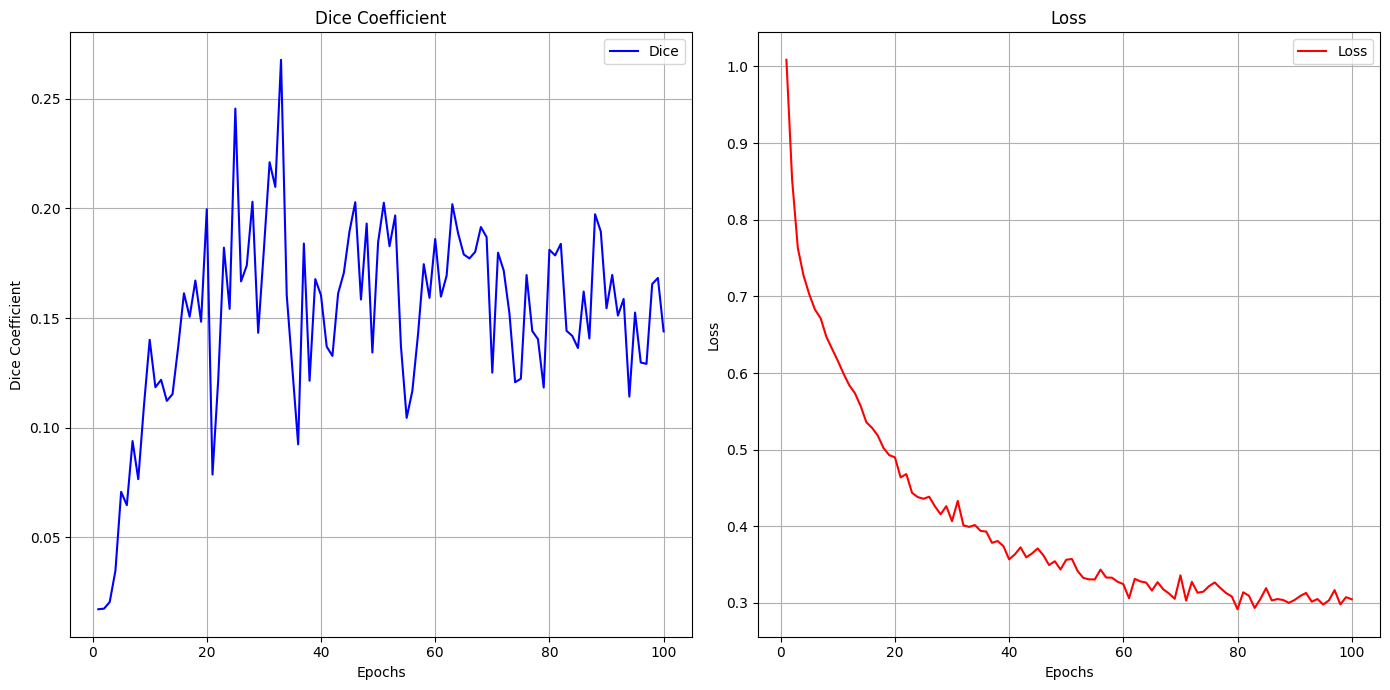

In [ ]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()